In [1]:
# Implementation of OLS to determine trnd of daily cell phone usage 
# For 100_0000 users in 14 days

In [24]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


In [2]:
# Generate synthetic data
out = 'synthetic_ols_data.pickle'

NUM_DAYS = 14
NUM_PEOPLE = 100_000

LAMBDA = 60 # mean of 60 minutes

np.random.seed(0)

hours_per_day_per_person = np.random.poisson(lam=LAMBDA, size=(NUM_DAYS, NUM_PEOPLE)).T
print(hours_per_day_per_person)
hours_per_day_per_person = hours_per_day_per_person/60

df = pd.DataFrame(hours_per_day_per_person).astype(np.float_)
print(f"Writing {df.shape} to {out}")
df.to_pickle(out)

[[61 53 62 ... 58 61 50]
 [62 61 50 ... 54 68 53]
 [58 65 71 ... 68 60 57]
 ...
 [62 62 65 ... 62 62 55]
 [55 52 60 ... 69 66 63]
 [51 48 65 ... 51 77 67]]
Writing (100000, 14) to synthetic_ols_data.pickle


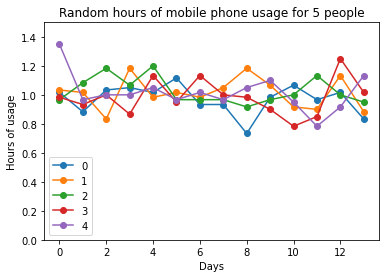

In [5]:
# Display synthetic data
ax = plt.subplot()
df[:5].T.plot(ax=ax, marker='o')
ax.set_title('Random hours of mobile phone usage for 5 people')
ax.set_xlabel('Days')
ax.set_ylabel('Hours of usage')
ax.set_ylim(0, 1.5)
ax.legend()

In [20]:
# Define OLS funcs

def ols_sklearn(row):
    """OLS through scikit learn Linear Regression"""
    est = LinearRegression()
    X = np.arange(row.shape[0]).reshape(-1,1)
    est.fit(X=X, y=row.values)
    m = est.coef_[0]
    return m

def ols_lstsq(row):
    """OLS through numpy.linalg.lstq"""
    # build X values for [1,13] -> 14 days
    X = np.arange(row.shape[0])
    ones = np.ones(row.shape[0]) # to build intercept
    A = np.vstack((X, ones)).T #shape(14,2)
    m, c = np.linalg.lstsq(A, row.values, rcond=-1)[0]
    return m

def ols_lstsq_raw(row):
    """Variant of `ols_lstsq` where input row is a numpy array (not a Series)"""
    X = np.arange(row.shape[0])
    ones = np.ones(row.shape[0])
    A = np.vstack((X, ones)).T
    m, c = np.linalg.lstsq(A, row, rcond=-1)[0] # row instead of row.values -> no series
    return m



In [21]:
# ols_lestsq outperforms ols_sklearn since it does not perform data checks and preprocessing internally

import timeit
df = pd.read_pickle('synthetic_ols_data.pickle')
print("Loaded")

number = 10_000

results = timeit.repeat("ols_lstsq(df.iloc[0])", globals=globals(), number=number)
time_of_fastest = min(results)
print(f"Time to run ols_lstsq for fastest of repeats is {time_of_fastest / number:0.6f} seconds on {number} repeats and taking fastest")

results = timeit.repeat("ols_sklearn(df.iloc[0])", globals=globals(), number=number)
time_of_fastest = min(results)
print(f"Time to run ols_sklearn for fastest of repeats is {time_of_fastest / number:0.6f} seconds")



Loaded
Time to run ols_lstsq for fastest of repeats is 0.000113 seconds on 10000 repeats and taking fastest
Time to run ols_sklearn for fastest of repeats is 0.000329 seconds


In [25]:
# counting and fetching rows one at a time with iloc -> worst approach 11.4 seconds
ms =[]
for row_idx in range(df.shape[0]):
    row = df.iloc[row_idx]
    m = ols_lstsq(row)
    ms.append(m)

results = pd.Series(ms)

In [26]:
# using iterrows instead of iloc -> 9.1 seconds
ms = []
for row_idx, row in df.iterrows():
    m = ols_lstsq(row)
    ms.append(m)
results = pd.Series(ms)

In [27]:
# using df.apply -> 5.7 seconds
# fresh series is constructed for each row behind the scenes
ms = df.apply(ols_lstsq, axis=1)
results = pd.Series(ms)

In [28]:
# using df.apply raw=True -> 4.9 seconds
ms = df.apply(ols_lstsq_raw, axis=1, raw=True)
results = pd.Series(ms)